# Sartorius Segmentation By U-Net [Inference]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import json

import cv2
import glob
from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

# Function

In [ ]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

# UNET model

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

class FixedDropout(keras.layers.Dropout):
    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]
        return tuple(noise_shape)
def dice_coef_rounded(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
custom_objects = custom_objects={
    #'swish': tf.nn.swish,
    'FixedDropout': FixedDropout,
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
    #'GroupNormalization': GroupNormalization,
    #'AccumOptimizer': Adam, # Placeholder, does not matter since we are not modifying the model
    #'dice_coef_rounded': dice_coef_rounded

}
unet = load_model('../input/sartorius-segmentation-unet/model.h5', custom_objects=custom_objects)

#unet.summary()

2021-11-01 04:50:37.795618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 04:50:37.887585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 04:50:37.888309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 04:50:37.890262: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Prediction

In [ ]:
def build_rles(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
sub_df = pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')
sub_df.head()

,id,predicted
0,7ae19de7bc2a,NaN
1,d48ec7815252,NaN
2,d8bfd1dafdc4,NaN


In [ ]:
IMG_SIZE=256
# Get and resize test images
sample_submission = pd.read_csv('../input/sartorius-cell-instance-segmentation/sample_submission.csv')
test_ids = sample_submission['id'].unique().tolist()

X_test = np.zeros((sample_submission['id'].nunique(), IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
print('Getting and resizing test images ... ')

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = f'../input/sartorius-cell-instance-segmentation/test/{id_}.png'
    print(path)
    img = imread(path)[:,:]
    img = resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis = 2)
    X_test[n] = img

print('Done!')

print(X_test.shape)

Getting and resizing test images ... 


100%|██████████| 3/3 [00:00<00:00, 25.86it/s]

../input/sartorius-cell-instance-segmentation/test/7ae19de7bc2a.png
../input/sartorius-cell-instance-segmentation/test/d48ec7815252.png
../input/sartorius-cell-instance-segmentation/test/d8bfd1dafdc4.png
Done!
(3, 256, 256, 3)


In [ ]:
preds_test = unet.predict(X_test, verbose=1)

2021-11-01 04:50:45.660948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-01 04:50:47.870911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/1 [==============================] - 8s 8s/step


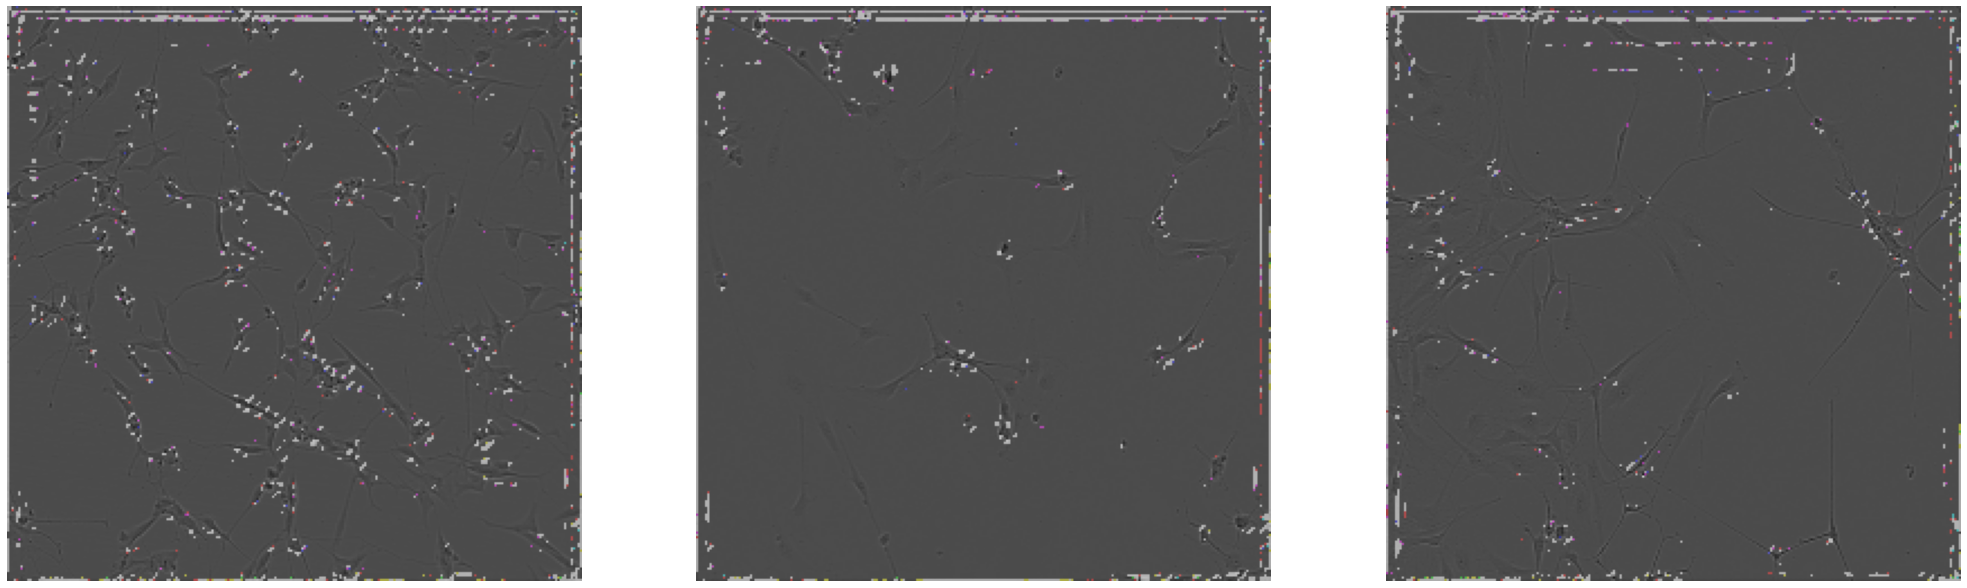

In [ ]:
threshold=0.5
max_images = 3
grid_width = 3

grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(35, 35))
for i, idx in enumerate(preds_test[:max_images]):
    ax = axs[i]
    img = X_test[i]
    ax.imshow(img)

    pred = (preds_test[i] > threshold).astype(np.float32)
    ax.imshow(pred, alpha=0.4, cmap="Reds")

    ax.axis('off')

In [ ]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (IMG_SIZE, IMG_SIZE,1),
                                       mode='constant', preserve_range=True))

preds_test_upsampled[0].shape

(256, 256, 1)

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = (x > cutoff).astype(int)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
def post_process(probability,min_size=300):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = []
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            a_prediction = np.zeros((520, 704), np.float32)
            a_prediction[p] = 1
            predictions.append(a_prediction)
    return predictions

In [ ]:
output_df = pd.DataFrame(data = None, columns = sample_submission.columns)
count = 0

for n, id_ in enumerate(test_ids):
    probability_mask = cv2.resize(preds_test_upsampled[n], dsize=(704, 520), interpolation=cv2.INTER_LINEAR)
    predictions = post_process(probability_mask)
    rle = [list(prob_to_rles(predictions[i]))[0] for i in range(0, len(predictions))]
    for i in range(0, len(rle)):
        cell_annotations = ' '.join([str(x) for x in rle[i]])
        output_df.loc[count] = id_,cell_annotations
        count +=1

output_df.to_csv('submission.csv', index = False)
output_df

,id,predicted
0,7ae19de7bc2a,5818 12 5837 7 5856 2 6519 17 6540 13 6558 5 6...
1,7ae19de7bc2a,5936 4 5947 7 5958 2 5994 2 5999 2 6639 6 6649...
2,7ae19de7bc2a,40129 2 40833 3 41537 3 42241 3 42945 3 43649 ...
3,7ae19de7bc2a,128833 2 129537 3 130241 3 130945 3 131649 3 1...
4,d48ec7815252,2463 1 3159 12 3862 13 4567 5 5271 4 5972 7 59...
5,d48ec7815252,2891 109 3595 110 4304 7 5009 5 5715 6 6419 8 ...
6,d48ec7815252,3043 101 3747 102 4549 4 5254 4 5958 5 6643 4 ...
7,d48ec7815252,3208 159 3911 160
8,d48ec7815252,21121 2 21825 3 22529 3 23233 3 23937 3 24641 ...
9,d48ec7815252,221055 2 221759 2 222463 2 223166 3 223870 3 2...


In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

(-0.5, 703.5, 519.5, -0.5)

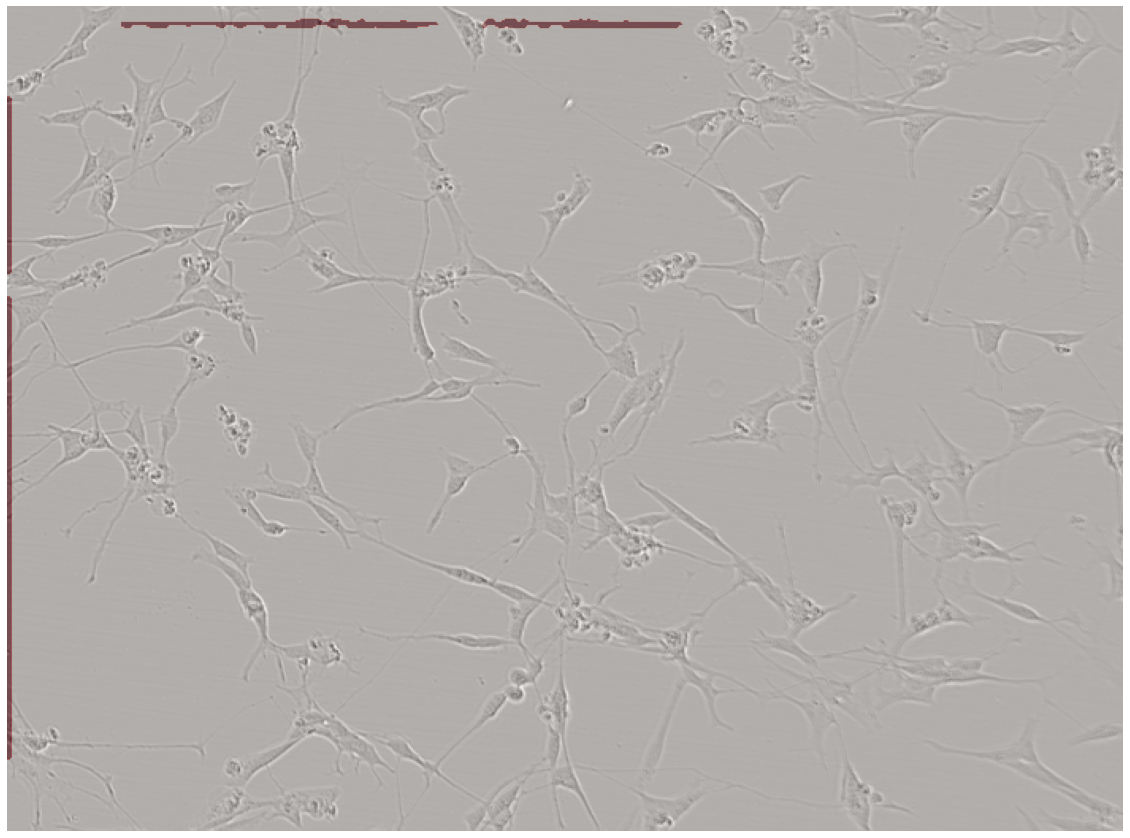

In [ ]:
sample_filename = '7ae19de7bc2a'
sample_image_df = output_df[output_df['id'] == sample_filename]
sample_path = f"../input/sartorius-cell-instance-segmentation/test/{sample_image_df['id'].iloc[0]}.png"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['predicted'].values

sample_masks=build_masks(sample_rles,input_shape=(520, 704), colors=False)


fig, axs = plt.subplots(figsize=(20, 20))
axs.imshow(sample_img)
axs.axis('off')
axs.imshow(sample_masks, alpha=0.4, cmap="Reds")
axs.axis('off')

